# Notebook 2
See notebook 1 about the approach. In this notebook, we take the output of the Fisher Exact analysis and plot it in a matrix. The matrix displays chromosomal bins that are in LD. This notebook takes the output of Notebook 1 in the form of the following files:
- a genomic bin file: chr_bin_bb_2021-06-12.pckle
- bb_main_stdval_peaks_npeaks_upeak=1.5_2021-06-12.pckle
- fisher_bb_df_upeak2_with_bh_0.05_2021-06-12.csv


In [1]:
#use iPython magin notation to make the plots appear inline
%matplotlib inline
#import all needed libraries
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats, integrate, interpolate
import os
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
from datetime import date
from collections import defaultdict
#this sets the font for legend in all operations
#plt.rc("legend", fontsize=12)
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [2]:
#set date for time stamping of file names
today = date.today().isoformat()
today 

'2021-06-16'

In [3]:
pop_name = 'bb'

In [4]:
# import chr_bin and make a bin df
# NOTE: Normally BIN has Bin (as index), Chrom	Start	End	bin_order
df_chr_bin = pd.read_pickle('/Users/lucacomai/Data_analysis/generic_cnv_analysis_with_latest_notebooks/cnv_mapping/chr_bin_bb_2021-06-12.pckle')
df_chr_bin.head()
# IMPORTANT: the bin and start numbers are based on 1, not 0
# e.g. bin 1 is from 1 to 1M (as 1000000)

,Chrom,Start,End,bino
Bin,,,,
chr01_1,chr01,1,1000000,1
chr01_1000001,chr01,1000001,2000000,2
chr01_2000001,chr01,2000001,3000000,3
chr01_3000001,chr01,3000001,4000000,4
chr01_4000001,chr01,4000001,5000000,5


In [5]:
# modify this chr bin 
lb_cols=['chr', 'strt', 'end','bin_order']
df_chr_bin.columns=lb_cols
df_chr_bin['chr_bin']=df_chr_bin['chr'].str[:]+'_'+df_chr_bin['strt'].astype(str)
df_chr_bin

,chr,strt,end,bin_order,chr_bin
Bin,,,,,
chr01_1,chr01,1,1000000,1,chr01_1
chr01_1000001,chr01,1000001,2000000,2,chr01_1000001
chr01_2000001,chr01,2000001,3000000,3,chr01_2000001
chr01_3000001,chr01,3000001,4000000,4,chr01_3000001
chr01_4000001,chr01,4000001,5000000,5,chr01_4000001
...,...,...,...,...,...
chr12_57000001,chr12,57000001,58000000,727,chr12_57000001
chr12_58000001,chr12,58000001,59000000,728,chr12_58000001
chr12_59000001,chr12,59000001,60000000,729,chr12_59000001


In [6]:
# if the number in the bins are floats .000.0, slice them out to get clean 001
#df_chr_bin['chr_bin']=chr_bin['chr_bin'].apply(lambda x: x[:-2])
# add the chromosome bins
df_chr_bin['target_chr_bin']=df_chr_bin['chr_bin']
df_chr_bin['target_bin_order']=df_chr_bin['bin_order']
df_chr_bin.tail()

,chr,strt,end,bin_order,chr_bin,target_chr_bin,target_bin_order
Bin,,,,,,,
chr12_57000001,chr12,57000001,58000000,727,chr12_57000001,chr12_57000001,727
chr12_58000001,chr12,58000001,59000000,728,chr12_58000001,chr12_58000001,728
chr12_59000001,chr12,59000001,60000000,729,chr12_59000001,chr12_59000001,729
chr12_60000001,chr12,60000001,61000000,730,chr12_60000001,chr12_60000001,730
chr12_61000001,chr12,61000001,61165649,731,chr12_61000001,chr12_61000001,731


In [7]:
# import the table of CN values with attached peak definitions, may need to change date
bb_p = pd.read_pickle('/Users/lucacomai/Data_analysis/generic_cnv_analysis_with_latest_notebooks/cnv_mapping/bb_main_stdval_peaks_npeaks_upeak=1.5_2021-06-12.pckle')
bb_p.head()

,Bin,10,102,110,116,119,12,158,163,167,...,38,41,51,56,60,85,92,peaks,valleys,n_peaks
0,chr01_1,2.092527,2.092727,1.958804,2.106958,2.085891,2.201892,2.164737,1.939870,1.817495,...,1.948398,2.291332,2.286476,2.282991,2.214389,2.231603,1.938393,[2.0],"[1.0, 3.5]",1
1,chr01_1000001,1.897634,1.992515,1.930888,1.876096,1.839949,1.890621,1.966854,1.992071,1.936170,...,1.844095,1.951093,1.999530,2.064906,1.929031,1.974855,1.971926,[1.9375],"[0.9375, 3.4375]",1
2,chr01_2000001,1.936323,1.772452,1.756655,1.871713,1.854947,1.913907,1.831408,1.880172,1.915661,...,1.893202,1.989300,1.978932,1.977100,1.925121,1.872328,1.919441,[1.875],"[0.9375, 3.4375]",1
3,chr01_3000001,1.789378,1.832632,1.867571,1.862491,1.911370,1.965331,2.128080,1.892276,1.860424,...,1.817245,1.877267,1.908174,1.967944,2.070008,1.894124,2.043170,[1.875],"[0.9375, 3.4375]",1
4,chr01_4000001,2.138072,2.130775,1.998562,2.231837,1.962093,2.138677,2.269630,2.087952,2.004899,...,2.137419,2.189273,2.209824,2.238846,2.043964,2.073360,2.061816,[2.0625],"[1.0, 3.5]",1


In [8]:
bb_p.shape

(731, 88)

In [9]:
len(bb_p.columns)

88

In [10]:
# make sure the first column is "chr_bin" and the last 3 are 'peaks', 'valleys', 'n_peaks'
bbcols=list(bb_p.columns)
# replace first column name
bbcols[0]='chr_bin'
bb_p.columns=bbcols
bb_p.head()


,chr_bin,10,102,110,116,119,12,158,163,167,...,38,41,51,56,60,85,92,peaks,valleys,n_peaks
0,chr01_1,2.092527,2.092727,1.958804,2.106958,2.085891,2.201892,2.164737,1.939870,1.817495,...,1.948398,2.291332,2.286476,2.282991,2.214389,2.231603,1.938393,[2.0],"[1.0, 3.5]",1
1,chr01_1000001,1.897634,1.992515,1.930888,1.876096,1.839949,1.890621,1.966854,1.992071,1.936170,...,1.844095,1.951093,1.999530,2.064906,1.929031,1.974855,1.971926,[1.9375],"[0.9375, 3.4375]",1
2,chr01_2000001,1.936323,1.772452,1.756655,1.871713,1.854947,1.913907,1.831408,1.880172,1.915661,...,1.893202,1.989300,1.978932,1.977100,1.925121,1.872328,1.919441,[1.875],"[0.9375, 3.4375]",1
3,chr01_3000001,1.789378,1.832632,1.867571,1.862491,1.911370,1.965331,2.128080,1.892276,1.860424,...,1.817245,1.877267,1.908174,1.967944,2.070008,1.894124,2.043170,[1.875],"[0.9375, 3.4375]",1
4,chr01_4000001,2.138072,2.130775,1.998562,2.231837,1.962093,2.138677,2.269630,2.087952,2.004899,...,2.137419,2.189273,2.209824,2.238846,2.043964,2.073360,2.061816,[2.0625],"[1.0, 3.5]",1


In [11]:
# place the chr_bin as index
bb_p.set_index('chr_bin', drop=False, inplace=True)
bb_p.head()

,chr_bin,10,102,110,116,119,12,158,163,167,...,38,41,51,56,60,85,92,peaks,valleys,n_peaks
chr_bin,,,,,,,,,,,,,,,,,,,,,
chr01_1,chr01_1,2.092527,2.092727,1.958804,2.106958,2.085891,2.201892,2.164737,1.939870,1.817495,...,1.948398,2.291332,2.286476,2.282991,2.214389,2.231603,1.938393,[2.0],"[1.0, 3.5]",1
chr01_1000001,chr01_1000001,1.897634,1.992515,1.930888,1.876096,1.839949,1.890621,1.966854,1.992071,1.936170,...,1.844095,1.951093,1.999530,2.064906,1.929031,1.974855,1.971926,[1.9375],"[0.9375, 3.4375]",1
chr01_2000001,chr01_2000001,1.936323,1.772452,1.756655,1.871713,1.854947,1.913907,1.831408,1.880172,1.915661,...,1.893202,1.989300,1.978932,1.977100,1.925121,1.872328,1.919441,[1.875],"[0.9375, 3.4375]",1
chr01_3000001,chr01_3000001,1.789378,1.832632,1.867571,1.862491,1.911370,1.965331,2.128080,1.892276,1.860424,...,1.817245,1.877267,1.908174,1.967944,2.070008,1.894124,2.043170,[1.875],"[0.9375, 3.4375]",1
chr01_4000001,chr01_4000001,2.138072,2.130775,1.998562,2.231837,1.962093,2.138677,2.269630,2.087952,2.004899,...,2.137419,2.189273,2.209824,2.238846,2.043964,2.073360,2.061816,[2.0625],"[1.0, 3.5]",1


In [12]:
# load the processed analysis
# read the csv file 
bb_pref_peaks = pd.read_csv('/Users/lucacomai/Data_analysis/generic_cnv_analysis_with_latest_notebooks/cnv_mapping/fisher_bb_df_upeak2_with_bh_0.05_2021-06-12.csv')
# again, bin must end in 1
#bb_pref_peaks['chr_bin']=bb_pref_peaks['chr_bin'].apply(lambda x: x[:-2])
#bb_pref_peaks['bin']=bb_pref_peaks['bin'].apply(lambda x: x[:-2])
#bb_pref_peaks['target_chr_bin']=bb_pref_peaks['target_chr_bin'].apply(lambda x: x[:-2])
#bb_pref_peaks['target_bin']=bb_pref_peaks['target_bin'].apply(lambda x: x[:-2])
bb_pref_peaks.tail()

,chr_bin,chr,bin,cluster,target_chr_bin,target_chr,target_bin,target_cluster,p,rel,obs_set1,lenset2,obs_matching_set2,obs_notmatching_set2,exp_matching_set2,exp_notmatching_set2,p_bh,fdr_0.05
21508,chr12_51000001,12,51000001,2,chr12_31000001,12,31000001,3,0.005217,neg,42,13,0,13,6,6,0.050621,False
21509,chr12_51000001,12,51000001,2,chr12_36000001,12,36000001,2,0.013730,neg,42,12,0,12,6,6,0.120586,False
21510,chr12_51000001,12,51000001,2,chr12_46000001,12,46000001,3,0.013730,neg,42,12,0,12,6,6,0.120586,False
21511,chr12_52000001,12,52000001,1,chr02_10000001,2,10000001,2,0.038935,pos,65,45,42,3,34,10,0.297629,False
21512,chr12_52000001,12,52000001,2,chr02_10000001,2,10000001,2,0.038935,neg,19,45,3,42,10,34,0.297629,False


In [13]:
# add a column that defines the peaks for the reference bin
# make dict of chr_bin and peaks
d_peaks = dict()
for chr_bin in bb_p["chr_bin"]:
    # building dict by extracting the value of each peak cell by indexing
    d_peaks[chr_bin]=bb_p.loc[chr_bin, "peaks"]

In [14]:
# process ref and target bins to make list of peaks 
ls_peaks2 = list()
for i in bb_pref_peaks.loc[:,"chr_bin"]:
    ls_peaks2.append(d_peaks[i])
# add column with peak values
bb_pref_peaks['peaks']=ls_peaks2

ls_target_peaks2 = list()
for i in bb_pref_peaks.loc[:,"target_chr_bin"]:
    ls_target_peaks2.append(d_peaks[i])
bb_pref_peaks['target_peaks']=ls_target_peaks2

bb_pref_peaks.tail()

,chr_bin,chr,bin,cluster,target_chr_bin,target_chr,target_bin,target_cluster,p,rel,obs_set1,lenset2,obs_matching_set2,obs_notmatching_set2,exp_matching_set2,exp_notmatching_set2,p_bh,fdr_0.05,peaks,target_peaks
21508,chr12_51000001,12,51000001,2,chr12_31000001,12,31000001,3,0.005217,neg,42,13,0,13,6,6,0.050621,False,"[1.75, 2.0625]","[1.125, 1.625, 2.25, 2.75]"
21509,chr12_51000001,12,51000001,2,chr12_36000001,12,36000001,2,0.013730,neg,42,12,0,12,6,6,0.120586,False,"[1.75, 2.0625]","[1.5, 1.875, 2.3125]"
21510,chr12_51000001,12,51000001,2,chr12_46000001,12,46000001,3,0.013730,neg,42,12,0,12,6,6,0.120586,False,"[1.75, 2.0625]","[1.25, 1.8125, 2.1875, 2.625]"
21511,chr12_52000001,12,52000001,1,chr02_10000001,2,10000001,2,0.038935,pos,65,45,42,3,34,10,0.297629,False,"[1.9375, 2.25]","[2.0625, 2.5]"
21512,chr12_52000001,12,52000001,2,chr02_10000001,2,10000001,2,0.038935,neg,19,45,3,42,10,34,0.297629,False,"[1.9375, 2.25]","[2.0625, 2.5]"


In [15]:
(15200001.0-1)/100000

152.0

In [16]:
# the format of bin screws up the coloring of chr_dist in plots (too many values). Reduce bins to 100k units
# for example, 15200001.0 -> 152
# note that if Mber is rerun on a read file it converts all values to 0
def Mber(input):
    if input < 2:
        return 1
    else:
        return int((input-1)/100000)
#Mber(14000001)
def posneg(input):
    if input > 0:
        return "pos"
    else:
        return 'neg'

In [17]:
Mber(60)

0

In [18]:
# this function assigns the value to a peak
'''
	A	B
0	1	[2.1, 3.7, 1.2]
1	2	[1.1, 4.9]
2	1	[2.5, 5.6, 7.3, 8.6]
3	3	[2.3, 6.1, 7.8, 9.8]

ls1 = list()
indexer(df1.loc[:,'B'],df1.loc[:,'A'],ls1)
df1['C']=ls1
df1

	A	B	C
0	1	[2.1, 3.7, 1.2]	2.1
1	2	[1.1, 4.9]	4.9
2	1	[2.5, 5.6, 7.3, 8.6]	2.5
3	3	[2.3, 6.1, 7.8, 9.8]	7.8
'''
def indexer(series1, series2, ls1): 
    for i,j in zip(series1, series2):
        #print(i,j)
        try:
            out = i[j-1]
            #print(out)
            ls1.append(out)
        except:
            IndexError
            j -= 1
            out = i[j-1]
            ls1.append(out)

In [19]:
# combine columns and extract the ref peak 
ls_peak = list()
indexer(bb_pref_peaks.loc[:,'peaks'],bb_pref_peaks.loc[:,'cluster'],ls_peak)
bb_pref_peaks['source_peak']=ls_peak

# combine columns and extract the target peak 
ls_tpeak = list()
indexer(bb_pref_peaks.loc[:,'target_peaks'],bb_pref_peaks.loc[:,'target_cluster'],ls_tpeak)
bb_pref_peaks['target_peak']=ls_tpeak

In [20]:
bb_pref_peaks.tail()

,chr_bin,chr,bin,cluster,target_chr_bin,target_chr,target_bin,target_cluster,p,rel,...,obs_matching_set2,obs_notmatching_set2,exp_matching_set2,exp_notmatching_set2,p_bh,fdr_0.05,peaks,target_peaks,source_peak,target_peak
21508,chr12_51000001,12,51000001,2,chr12_31000001,12,31000001,3,0.005217,neg,...,0,13,6,6,0.050621,False,"[1.75, 2.0625]","[1.125, 1.625, 2.25, 2.75]",2.0625,2.2500
21509,chr12_51000001,12,51000001,2,chr12_36000001,12,36000001,2,0.013730,neg,...,0,12,6,6,0.120586,False,"[1.75, 2.0625]","[1.5, 1.875, 2.3125]",2.0625,1.8750
21510,chr12_51000001,12,51000001,2,chr12_46000001,12,46000001,3,0.013730,neg,...,0,12,6,6,0.120586,False,"[1.75, 2.0625]","[1.25, 1.8125, 2.1875, 2.625]",2.0625,2.1875
21511,chr12_52000001,12,52000001,1,chr02_10000001,2,10000001,2,0.038935,pos,...,42,3,34,10,0.297629,False,"[1.9375, 2.25]","[2.0625, 2.5]",1.9375,2.5000
21512,chr12_52000001,12,52000001,2,chr02_10000001,2,10000001,2,0.038935,neg,...,3,42,10,34,0.297629,False,"[1.9375, 2.25]","[2.0625, 2.5]",2.2500,2.5000


In [21]:
bb_pref_peaks['interchr']=bb_pref_peaks['chr']!=bb_pref_peaks['target_chr']
bb_pref_peaks['peak_diff']=abs(bb_pref_peaks['source_peak']-bb_pref_peaks['target_peak'])
bb_pref_peaks.head()

,chr_bin,chr,bin,cluster,target_chr_bin,target_chr,target_bin,target_cluster,p,rel,...,exp_matching_set2,exp_notmatching_set2,p_bh,fdr_0.05,peaks,target_peaks,source_peak,target_peak,interchr,peak_diff
0,chr01_9000001,1,9000001,1,chr01_10000001,1,10000001,1,0.000011,pos,...,3,11,0.000218,True,"[1.1875, 2.125, 3.125]","[1.4375, 1.875, 2.5]",1.1875,1.4375,False,0.2500
1,chr01_9000001,1,9000001,1,chr01_10000001,1,10000001,2,0.015084,neg,...,10,42,0.131352,False,"[1.1875, 2.125, 3.125]","[1.4375, 1.875, 2.5]",1.1875,1.8750,False,0.6875
2,chr01_9000001,1,9000001,1,chr01_11000001,1,11000001,2,0.022618,neg,...,5,20,0.186456,False,"[1.1875, 2.125, 3.125]","[1.9375, 2.25]",1.1875,2.2500,False,1.0625
3,chr01_9000001,1,9000001,1,chr01_14000001,1,14000001,1,0.034438,pos,...,6,27,0.268955,False,"[1.1875, 2.125, 3.125]","[1.375, 1.8125, 2.75]",1.1875,1.3750,False,0.1875
4,chr01_9000001,1,9000001,1,chr01_14000001,1,14000001,3,0.022922,neg,...,5,21,0.188597,False,"[1.1875, 2.125, 3.125]","[1.375, 1.8125, 2.75]",1.1875,2.7500,False,1.5625


In [22]:
bb_pref_peaks['bin']=bb_pref_peaks['bin'].map(Mber)
bb_pref_peaks['target_bin']=bb_pref_peaks['target_bin'].map(Mber)
#lop_pref_peaks['cl_bias']=lop_pref_peaks['cluster_bias'].map(posneg)
bb_pref_peaks.tail()

,chr_bin,chr,bin,cluster,target_chr_bin,target_chr,target_bin,target_cluster,p,rel,...,exp_matching_set2,exp_notmatching_set2,p_bh,fdr_0.05,peaks,target_peaks,source_peak,target_peak,interchr,peak_diff
21508,chr12_51000001,12,510,2,chr12_31000001,12,310,3,0.005217,neg,...,6,6,0.050621,False,"[1.75, 2.0625]","[1.125, 1.625, 2.25, 2.75]",2.0625,2.2500,False,0.1875
21509,chr12_51000001,12,510,2,chr12_36000001,12,360,2,0.013730,neg,...,6,6,0.120586,False,"[1.75, 2.0625]","[1.5, 1.875, 2.3125]",2.0625,1.8750,False,0.1875
21510,chr12_51000001,12,510,2,chr12_46000001,12,460,3,0.013730,neg,...,6,6,0.120586,False,"[1.75, 2.0625]","[1.25, 1.8125, 2.1875, 2.625]",2.0625,2.1875,False,0.1250
21511,chr12_52000001,12,520,1,chr02_10000001,2,100,2,0.038935,pos,...,34,10,0.297629,False,"[1.9375, 2.25]","[2.0625, 2.5]",1.9375,2.5000,True,0.5625
21512,chr12_52000001,12,520,2,chr02_10000001,2,100,2,0.038935,neg,...,10,34,0.297629,False,"[1.9375, 2.25]","[2.0625, 2.5]",2.2500,2.5000,True,0.2500


In [23]:
bb_pref_peaks['cluster_bias']=(bb_pref_peaks['obs_matching_set2']/bb_pref_peaks['lenset2']-bb_pref_peaks['exp_matching_set2']/bb_pref_peaks['lenset2'])
bb_pref_peaks['chrom_dist']=abs(bb_pref_peaks['bin']-bb_pref_peaks['target_bin'])
bb_pref_peaks['abs_cbias']=abs(bb_pref_peaks['cluster_bias'])
bb_pref_peaks.head()

,chr_bin,chr,bin,cluster,target_chr_bin,target_chr,target_bin,target_cluster,p,rel,...,fdr_0.05,peaks,target_peaks,source_peak,target_peak,interchr,peak_diff,cluster_bias,chrom_dist,abs_cbias
0,chr01_9000001,1,90,1,chr01_10000001,1,100,1,0.000011,pos,...,True,"[1.1875, 2.125, 3.125]","[1.4375, 1.875, 2.5]",1.1875,1.4375,False,0.2500,0.800000,10,0.800000
1,chr01_9000001,1,90,1,chr01_10000001,1,100,2,0.015084,neg,...,False,"[1.1875, 2.125, 3.125]","[1.4375, 1.875, 2.5]",1.1875,1.8750,False,0.6875,-0.150943,10,0.150943
2,chr01_9000001,1,90,1,chr01_11000001,1,110,2,0.022618,neg,...,False,"[1.1875, 2.125, 3.125]","[1.9375, 2.25]",1.1875,2.2500,False,1.0625,-0.192308,20,0.192308
3,chr01_9000001,1,90,1,chr01_14000001,1,140,1,0.034438,pos,...,False,"[1.1875, 2.125, 3.125]","[1.375, 1.8125, 2.75]",1.1875,1.3750,False,0.1875,0.264706,50,0.264706
4,chr01_9000001,1,90,1,chr01_14000001,1,140,3,0.022922,neg,...,False,"[1.1875, 2.125, 3.125]","[1.375, 1.8125, 2.75]",1.1875,2.7500,False,1.5625,-0.185185,50,0.185185


In [24]:
bb_pref_peaks.head()

,chr_bin,chr,bin,cluster,target_chr_bin,target_chr,target_bin,target_cluster,p,rel,...,fdr_0.05,peaks,target_peaks,source_peak,target_peak,interchr,peak_diff,cluster_bias,chrom_dist,abs_cbias
0,chr01_9000001,1,90,1,chr01_10000001,1,100,1,0.000011,pos,...,True,"[1.1875, 2.125, 3.125]","[1.4375, 1.875, 2.5]",1.1875,1.4375,False,0.2500,0.800000,10,0.800000
1,chr01_9000001,1,90,1,chr01_10000001,1,100,2,0.015084,neg,...,False,"[1.1875, 2.125, 3.125]","[1.4375, 1.875, 2.5]",1.1875,1.8750,False,0.6875,-0.150943,10,0.150943
2,chr01_9000001,1,90,1,chr01_11000001,1,110,2,0.022618,neg,...,False,"[1.1875, 2.125, 3.125]","[1.9375, 2.25]",1.1875,2.2500,False,1.0625,-0.192308,20,0.192308
3,chr01_9000001,1,90,1,chr01_14000001,1,140,1,0.034438,pos,...,False,"[1.1875, 2.125, 3.125]","[1.375, 1.8125, 2.75]",1.1875,1.3750,False,0.1875,0.264706,50,0.264706
4,chr01_9000001,1,90,1,chr01_14000001,1,140,3,0.022922,neg,...,False,"[1.1875, 2.125, 3.125]","[1.375, 1.8125, 2.75]",1.1875,2.7500,False,1.5625,-0.185185,50,0.185185


In [25]:
df_chr_bin.head()

,chr,strt,end,bin_order,chr_bin,target_chr_bin,target_bin_order
Bin,,,,,,,
chr01_1,chr01,1,1000000,1,chr01_1,chr01_1,1
chr01_1000001,chr01,1000001,2000000,2,chr01_1000001,chr01_1000001,2
chr01_2000001,chr01,2000001,3000000,3,chr01_2000001,chr01_2000001,3
chr01_3000001,chr01,3000001,4000000,4,chr01_3000001,chr01_3000001,4
chr01_4000001,chr01,4000001,5000000,5,chr01_4000001,chr01_4000001,5


In [26]:
bb_result = pd.merge(bb_pref_peaks, df_chr_bin.loc[:,['chr_bin','bin_order']], on='chr_bin', how='left')
bb_result = pd.merge(bb_result, df_chr_bin.loc[:,['target_chr_bin','target_bin_order']], on='target_chr_bin', how='left')
bb_result.head()

,chr_bin,chr,bin,cluster,target_chr_bin,target_chr,target_bin,target_cluster,p,rel,...,target_peaks,source_peak,target_peak,interchr,peak_diff,cluster_bias,chrom_dist,abs_cbias,bin_order,target_bin_order
0,chr01_9000001,1,90,1,chr01_10000001,1,100,1,0.000011,pos,...,"[1.4375, 1.875, 2.5]",1.1875,1.4375,False,0.2500,0.800000,10,0.800000,10,11
1,chr01_9000001,1,90,1,chr01_10000001,1,100,2,0.015084,neg,...,"[1.4375, 1.875, 2.5]",1.1875,1.8750,False,0.6875,-0.150943,10,0.150943,10,11
2,chr01_9000001,1,90,1,chr01_11000001,1,110,2,0.022618,neg,...,"[1.9375, 2.25]",1.1875,2.2500,False,1.0625,-0.192308,20,0.192308,10,12
3,chr01_9000001,1,90,1,chr01_14000001,1,140,1,0.034438,pos,...,"[1.375, 1.8125, 2.75]",1.1875,1.3750,False,0.1875,0.264706,50,0.264706,10,15
4,chr01_9000001,1,90,1,chr01_14000001,1,140,3,0.022922,neg,...,"[1.375, 1.8125, 2.75]",1.1875,2.7500,False,1.5625,-0.185185,50,0.185185,10,15


In [27]:
bb_result.head()
bb_result.to_pickle('bb_result_fromldmatrix_upeak2_'+today+'.pckle')
bb_result.to_csv('bb_result_fromldmatrix_upeak2_'+today+'.csv')

In [28]:
# how many bins are involved as source or target? Filter for BH p
bb_resbh = bb_result.where(bb_result['fdr_0.05']==True)
all_bins = pd.concat((bb_resbh['chr_bin'],bb_resbh['target_chr_bin']))
all_bins.value_counts()[:10]

chr12_17000001    351
chr12_44000001    350
chr12_31000001    340
chr12_29000001    331
chr12_24000001    331
chr12_46000001    326
chr12_39000001    321
chr12_32000001    320
chr12_34000001    313
chr12_14000001    311
dtype: int64

In [29]:
bb_resbh_inter = bb_resbh.where(bb_resbh['interchr']==True)
all_bins = pd.concat((bb_resbh_inter['chr_bin'],bb_resbh_inter['target_chr_bin']))

all_bins.value_counts()[:10]

chr04_13000001    167
chr04_14000001    163
chr01_25000001     88
chr01_24000001     49
chr08_56000001     48
chr08_53000001     48
chr08_52000001     48
chr08_55000001     48
chr08_54000001     48
chr07_55000001     46
dtype: int64

In [30]:
# summarize the number of LD instances that are interchromosomal and 
# how many satisfy FDR < 5%
pd.crosstab(bb_result['fdr_0.05'],bb_result['interchr'])

interchr,False,True
fdr_0.05,,
False,4714,474
True,15561,764


In [31]:
# extract chromosome start bin
df_chr_bin.head()

,chr,strt,end,bin_order,chr_bin,target_chr_bin,target_bin_order
Bin,,,,,,,
chr01_1,chr01,1,1000000,1,chr01_1,chr01_1,1
chr01_1000001,chr01,1000001,2000000,2,chr01_1000001,chr01_1000001,2
chr01_2000001,chr01,2000001,3000000,3,chr01_2000001,chr01_2000001,3
chr01_3000001,chr01,3000001,4000000,4,chr01_3000001,chr01_3000001,4
chr01_4000001,chr01,4000001,5000000,5,chr01_4000001,chr01_4000001,5


In [33]:
# I have an inconsistent naming issue. The column "bin_order" is sometime called "bino"
# ouch!
binmax=df_chr_bin['bin_order'].max()

In [34]:
df_chr_bin.head()

,chr,strt,end,bin_order,chr_bin,target_chr_bin,target_bin_order
Bin,,,,,,,
chr01_1,chr01,1,1000000,1,chr01_1,chr01_1,1
chr01_1000001,chr01,1000001,2000000,2,chr01_1000001,chr01_1000001,2
chr01_2000001,chr01,2000001,3000000,3,chr01_2000001,chr01_2000001,3
chr01_3000001,chr01,3000001,4000000,4,chr01_3000001,chr01_3000001,4
chr01_4000001,chr01,4000001,5000000,5,chr01_4000001,chr01_4000001,5


In [36]:
# get rightmost chromosomal bin
pcb=df_chr_bin.loc[:,['chr','bin_order']]
pgr=pcb.groupby('chr').min()
chr_start=list(pgr['bin_order'])
# adjust the start by one
chr_start2=[x-1 for x in chr_start]
# add last bin
chr_start2.append(binmax)
chr_start2

[0, 89, 138, 201, 274, 327, 387, 444, 501, 563, 623, 669, 731]

In [37]:
bb_result.head()

,chr_bin,chr,bin,cluster,target_chr_bin,target_chr,target_bin,target_cluster,p,rel,...,target_peaks,source_peak,target_peak,interchr,peak_diff,cluster_bias,chrom_dist,abs_cbias,bin_order,target_bin_order
0,chr01_9000001,1,90,1,chr01_10000001,1,100,1,0.000011,pos,...,"[1.4375, 1.875, 2.5]",1.1875,1.4375,False,0.2500,0.800000,10,0.800000,10,11
1,chr01_9000001,1,90,1,chr01_10000001,1,100,2,0.015084,neg,...,"[1.4375, 1.875, 2.5]",1.1875,1.8750,False,0.6875,-0.150943,10,0.150943,10,11
2,chr01_9000001,1,90,1,chr01_11000001,1,110,2,0.022618,neg,...,"[1.9375, 2.25]",1.1875,2.2500,False,1.0625,-0.192308,20,0.192308,10,12
3,chr01_9000001,1,90,1,chr01_14000001,1,140,1,0.034438,pos,...,"[1.375, 1.8125, 2.75]",1.1875,1.3750,False,0.1875,0.264706,50,0.264706,10,15
4,chr01_9000001,1,90,1,chr01_14000001,1,140,3,0.022922,neg,...,"[1.375, 1.8125, 2.75]",1.1875,2.7500,False,1.5625,-0.185185,50,0.185185,10,15


In [38]:
# make FDR result
lrf=bb_result.where(bb_result['fdr_0.05']==True)
lrf_inter=lrf.where(lrf['interchr']==True)
lrf_intra=lrf.where(lrf['interchr']==False)
lr_inter=bb_result.where(bb_result['interchr']==True)

In [39]:
lrf_intra.head()

,chr_bin,chr,bin,cluster,target_chr_bin,target_chr,target_bin,target_cluster,p,rel,...,target_peaks,source_peak,target_peak,interchr,peak_diff,cluster_bias,chrom_dist,abs_cbias,bin_order,target_bin_order
0,chr01_9000001,1.0,90.0,1.0,chr01_10000001,1.0,100.0,1.0,0.000011,pos,...,"[1.4375, 1.875, 2.5]",1.1875,1.4375,0.0,0.25,0.8,10.0,0.8,10.0,11.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


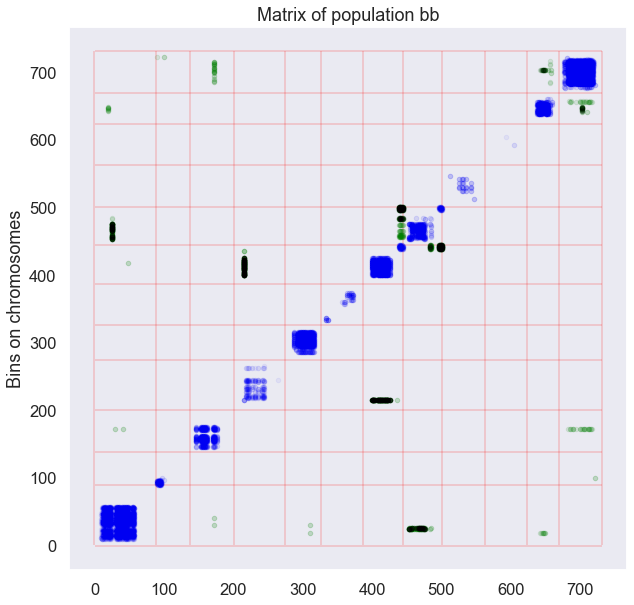

In [51]:
# Plot matrix 
sns.set_style('dark', {'font.sans-serif':'Arial',})
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(10,10))
ax.plot('bin_order', 'target_bin_order', 'b.', alpha=0.05,data=lrf_intra)
# this command plots the lower significance data as green points. Can skip if desired
ax.plot('bin_order', 'target_bin_order', 'g.', alpha=0.1,data=lr_inter)
# the high significance data is plotted in black (interchromosomal)
ax.plot('bin_order', 'target_bin_order', 'k.', alpha=0.1,data=lrf_inter)
#subax.text(-130,3,plant_names[k])
ax.vlines(chr_start2,1,binmax,linewidth=1.5, colors='r',alpha=0.2)
ax.hlines(chr_start2,1,binmax,linewidth=1.5, colors='r',alpha=0.2)
ax.set_ylabel('Bins on chromosomes')
ax.set_title('Matrix of population '+pop_name)
plt.savefig('matrix_result_ld_'+today+'.pdf')


Text(0.5, 1.0, 'Zoomed matrix of population bb')

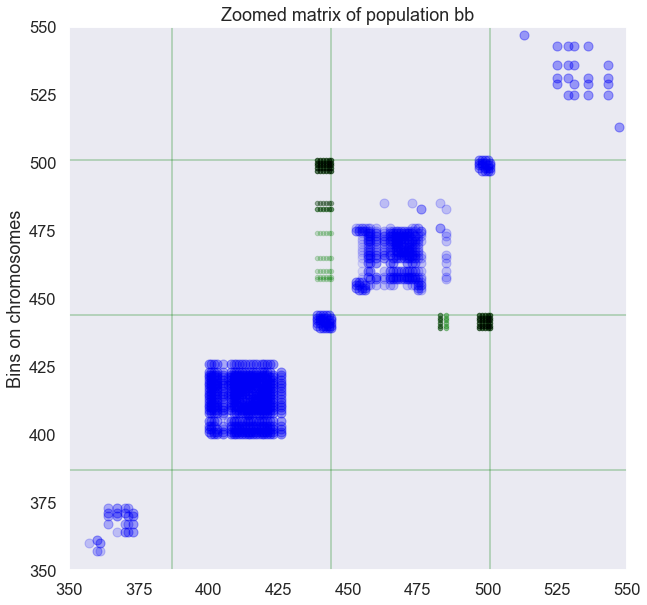

In [41]:
# plot a zoomed area
sns.set_style('dark', {'font.sans-serif':'Arial'})
fig, ax = plt.subplots(figsize=(10,10))
ax.plot('bin_order', 'target_bin_order', 'bo', alpha=0.1,data=lrf_intra)
ax.plot('bin_order', 'target_bin_order', 'g.', alpha=0.1,data=lr_inter)
ax.plot('bin_order', 'target_bin_order', 'k.', alpha=0.1,data=lrf_inter)
#ax.plot('bin_order', 'target_bin_order', 'b.', alpha=0.5,data=lrf_inter)
#subax.text(-130,3,plant_names[k])
#plt.ylim(1,731)
ax.vlines(chr_start2,1,731,linewidth=1.5, colors='g',alpha=0.3)
ax.hlines(chr_start2,1,731,linewidth=1.5, colors='g',alpha=0.3)
#plt.savefig('bb_ld_zoom'+today+'.pdf')
ax.set_xlim(350, 550)
ax.set_ylim(350, 550)
ax.set_ylabel('Bins on chromosomes')
ax.set_title('Zoomed matrix of population '+pop_name)

#plt.savefig('bb4x_ld_11_12_'+today+'.pdf') 


In [79]:
bb_values.shape

(731, 84)

# Correlation instead of Fisher Exact test
One can get good information by simply running a correlation test. The input can be the starting bin values or the peak centered values. In this case, the translocation between chr. 7 and chr. 8 is clearly visible. Correlation has the advantage to skip all the peak finding. On the other hand, it is prone to noise from small shifts in dosages, which can sometime be artefactual. This is based on experience with other dataset. In any case, it is certainly worth trying. 

Text(0.5, 1.0, 'Correlation matrix of population bb')

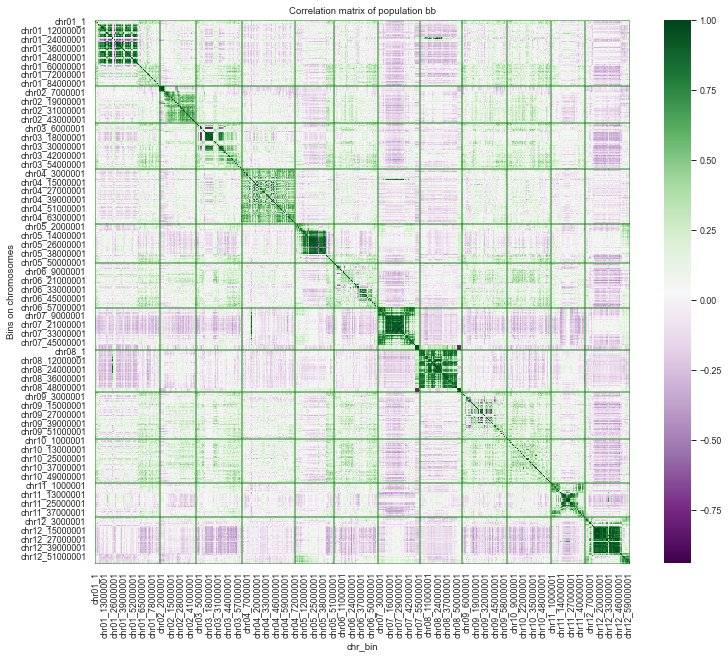

In [49]:
# for comparison purpose, make a correlation 
# this is the file of values with rows as bins and columns as lines. 
# running corr on it, generate line-line correlation. Therefore, make index from bins (col 1) transpose table
#lop_values.head()
sns.set_context('paper')
bb_values=bb_p.iloc[:,1:-3].copy()
bb_valuesT = bb_values.transpose().reset_index(drop=True)
bb_valcorr = bb_valuesT.corr()
#bb_valuesT.tail()
#lop_valcorr.head()
# the resulting df has bin id in the index and the column headers
fig, ax = plt.subplots(figsize=(12,10))
ax = sns.heatmap(bb_valcorr, cmap="PRGn")
# the axis have 731 points, like the df
ax.vlines(chr_start2,1,731,linewidth=1.5, colors='g',alpha=0.6)
ax.hlines(chr_start2,1,731,linewidth=1.5, colors='g',alpha=0.6)
ax.set_ylabel('Bins on chromosomes')
ax.set_title('Correlation matrix of population '+pop_name)
#bb_values
#plt.savefig('bb4x_corr_all_'+today+'.pdf')


In [43]:
bb_values.head()

,10,102,110,116,119,12,158,163,167,179,...,320,35,36,38,41,51,56,60,85,92
chr_bin,,,,,,,,,,,,,,,,,,,,,
chr01_1,2.092527,2.092727,1.958804,2.106958,2.085891,2.201892,2.164737,1.939870,1.817495,2.159765,...,2.064400,2.281464,2.056352,1.948398,2.291332,2.286476,2.282991,2.214389,2.231603,1.938393
chr01_1000001,1.897634,1.992515,1.930888,1.876096,1.839949,1.890621,1.966854,1.992071,1.936170,1.922035,...,2.014076,1.920225,1.965836,1.844095,1.951093,1.999530,2.064906,1.929031,1.974855,1.971926
chr01_2000001,1.936323,1.772452,1.756655,1.871713,1.854947,1.913907,1.831408,1.880172,1.915661,1.798333,...,2.073330,1.974799,1.908027,1.893202,1.989300,1.978932,1.977100,1.925121,1.872328,1.919441
chr01_3000001,1.789378,1.832632,1.867571,1.862491,1.911370,1.965331,2.128080,1.892276,1.860424,1.883720,...,1.964451,2.052592,1.833749,1.817245,1.877267,1.908174,1.967944,2.070008,1.894124,2.043170
chr01_4000001,2.138072,2.130775,1.998562,2.231837,1.962093,2.138677,2.269630,2.087952,2.004899,2.061591,...,2.237613,2.247931,2.051870,2.137419,2.189273,2.209824,2.238846,2.043964,2.073360,2.061816


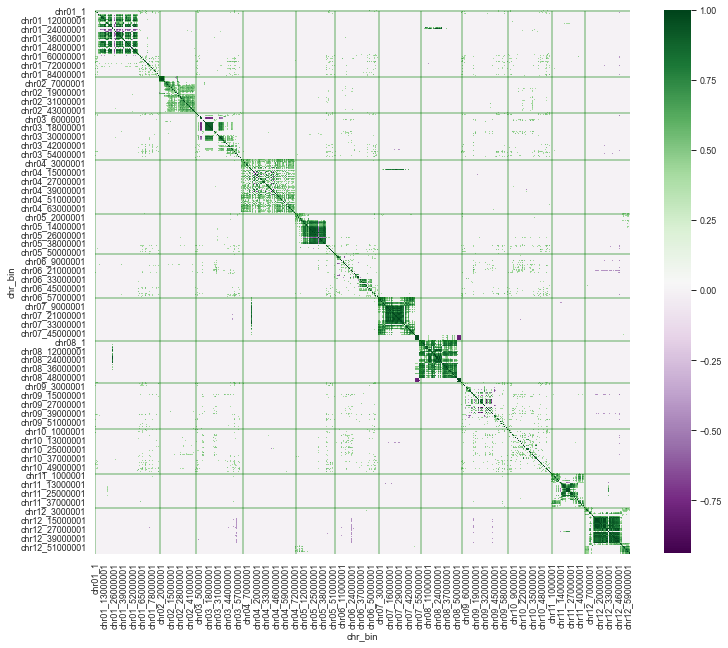

In [48]:
# for the purpose of discoverying LD, it is useful to highlight high correlation only
# make function that trims results to leave only the mid to high correlation data
def edger(x):
    if x >0.4:
        return x
    elif x <-0.4:
        return x
    else:
        return 0
bb_vc_gate=bb_valcorr.applymap(edger)
#bb_vc_gate.head()
fig, ax = plt.subplots(figsize=(12,10))
ax = sns.heatmap(bb_vc_gate, cmap="PRGn")
# the axis have 731 points, like the df
ax.vlines(chr_start,1,731,linewidth=1.5, colors='g',alpha=0.4)
ax.hlines(chr_start,1,731,linewidth=1.5, colors='g',alpha=0.4)
# plt.savefig('bb4x_ld_all_0.4filter_'+today+'.pdf')